# Machine Learning Case Study

*You haven't been to America if you haven't been to New York.*

New York is known for its world-famous sights, drawing millions of tourists into the city every year. Considering Times Square alone, we could see from online articles and videos that it is packed with people almost always. Because of this, there is a high demand for transportation services to get around the city. Some people would prefer to take the subway for affordability, whereas others would prefer taxis for convenience and comfort. The large number of taxi rides taken every day could give us an insight into traffic patterns that could lead to longer trip durations and peak hours that could influence trip fare. Insights drawn from this machine learning case study could help commuters decide on the optimal time to take a taxi. Furthermore, the insights could also help drivers determine the peak hours to maximize profits.

The dataset used in this case study is the [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/) dataset. In this machine learning case study, we will look into how the taxi fare can be predicted by extracted features. We will start by considering distance and time features when predicting the taxi fare, then we will proceed to consider only the time features when predicting taxi fare.

# Get Dataset

## Load Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from time import time

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/data/kaggle/taxi/

/content/drive/MyDrive/data/kaggle/taxi


## Load Dataset

This is a large dataset consisting of 26173536 samples. For our case, we will only deal with the first 1500000 samples, thus we are only utilizing approximately 5.73% of the entire dataset. The number of samples to be used in this case study was determined through trial-and-error by considering the memory usage and runtime of the functions and models laid out in this notebook.

In [ ]:
df = pd.read_csv('train.csv', nrows=1500000)
init_len = len(df)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Next, we want to get a concise summary of the dataset using `pandas.DataFrame.info`.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1500000 non-null  object 
 1   fare_amount        1500000 non-null  float64
 2   pickup_datetime    1500000 non-null  object 
 3   pickup_longitude   1500000 non-null  float64
 4   pickup_latitude    1500000 non-null  float64
 5   dropoff_longitude  1499988 non-null  float64
 6   dropoff_latitude   1499988 non-null  float64
 7   passenger_count    1500000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 91.6+ MB


Later in this notebook, we will convert the `pickupdate_datetime` column to a `datetime` object using `pandas.to_datetime`, and we could also extract the distance traveled using the pickup and dropoff longitudes and latitudes. Moving on, we would also like to determine how many missing values are present in the dataset.

In [ ]:
df.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    12
dropoff_latitude     12
passenger_count       0
dtype: int64

We then drop the rows with missing values and also drop duplicate rows.

In [ ]:
df = df.drop(['key'], axis=1)
df = df.drop_duplicates()
df.dropna(inplace=True)
drop_len = len(df)
print(f'Rows dropped: {init_len-drop_len}')

Rows dropped: 14


# EDA

Given how large the dataset is, we could expect possible outliers in the dataset's distribution. To begin with, let us see the distribution of the `fare_amount` column (target column).

In [ ]:
df[['fare_amount']].describe(percentiles=[.50, .75, .90, .95])

,fare_amount
count,1.499986e+06
mean,1.134972e+01
std,9.878693e+00
min,-6.200000e+01
50%,8.500000e+00
75%,1.250000e+01
90%,2.050000e+01
95%,3.033000e+01
max,1.273310e+03


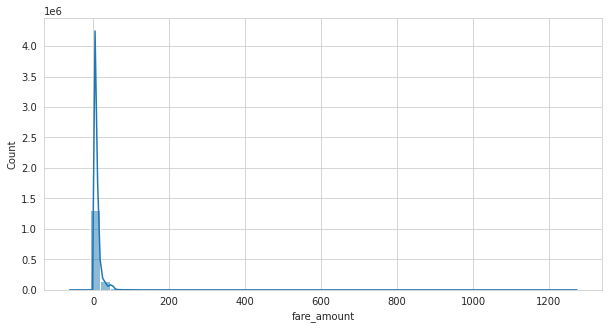

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=50, kde=True);

We see that the 95th-percentile of the target distribution (`fare_amount`) is \$30.3. Moreover, it is quite clear that there are outliers that affect the distribution of the target column greatly. To avoid outliers from affecting model training, we will only select rows in the dataset whose `fare_amount` is between \$0 and \$60 (this range was arbitrarily chosen through trial-and-error)
.

**Note:** This greatly affects the ability of our model to generalize to unseen data, especially data belonging to a different distribution. However, for this case study, we shouldn't concern ourselves too much on this aspect and just focus on training our model on a more balanced data distribution.

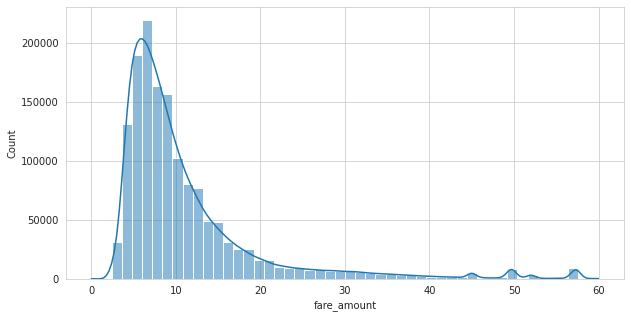

In [ ]:
df = df[df['fare_amount'].between(0, 60)]
plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=50, kde=True);

We would also like to look at the distributions of the pickup and dropoff longitudes and latitudes. It's possible that outliers are present, and thus we would like to remove those outliers to not affect model training.

In [ ]:
df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
    'dropoff_latitude']].describe([.50,.75,.90,.95])

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.495886e+06,1.495886e+06,1.495886e+06,1.495886e+06
mean,-7.253704e+01,3.993417e+01,-7.253698e+01,3.993423e+01
std,1.264994e+01,8.059298e+00,1.221820e+01,1.000131e+01
min,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03
50%,-7.398181e+01,4.075266e+01,-7.398013e+01,4.075319e+01
75%,-7.396715e+01,4.076712e+01,-7.396370e+01,4.076811e+01
90%,-7.395091e+01,4.077978e+01,-7.394566e+01,4.078276e+01
95%,-7.387279e+01,4.078773e+01,-7.388108e+01,4.079374e+01
max,2.522271e+03,2.621628e+03,2.842474e+03,3.345917e+03


Upon viewing the generated descriptive statistics of the pickup and dropoff longitudes and latitudes, we truncate the dataset with the selected ranges presented below (again, these ranges were abritrarily chosen through trial-and-error), removing any row not belonging to these ranges.

In [ ]:
df = df[df['pickup_longitude'].between(-75, -72)]
df = df[df['pickup_latitude'].between(39, 42)]
df = df[df['dropoff_longitude'].between(-75, -72)]
df = df[df['dropoff_latitude'].between(39, 42)]
print(f'Rows dropped: {drop_len-len(df)}')

Rows dropped: 34693


Let us now see the descriptive statistics of our pruned dataset.

In [ ]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.465293e+06,1.465293e+06,1.465293e+06,1.465293e+06,1.465293e+06,1.465293e+06
mean,1.114619e+01,-7.397524e+01,4.075094e+01,-7.397412e+01,4.075130e+01,1.684321e+00
std,8.886562e+00,3.873476e-02,3.198014e-02,3.687440e-02,3.486670e-02,1.307239e+00
min,0.000000e+00,-7.497287e+01,3.922555e+01,-7.498156e+01,3.922711e+01,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073656e+01,-7.399155e+01,4.073565e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398058e+01,4.075389e+01,1.000000e+00
75%,1.250000e+01,-7.396834e+01,4.076754e+01,-7.396535e+01,4.076840e+01,2.000000e+00
max,6.000000e+01,-7.270287e+01,4.180025e+01,-7.269484e+01,4.192382e+01,6.000000e+00


# Feature Engineering

At this point, we would like to perform feature engineering to extract features from the dataset that could boost model training and performance in predicting the target variable.

To begin with, we see that we have the pickup and dropoff longitudes and latitudes. These columns could be used together to extract the distance traveled by the taxi. To extract the `distance` feature, we apply the Haversine formula. We use this formula because it determines the distance between two points on a sphere given their longitudes and latitudes. The assumption we make when using this formula is that we treat the Earth as a perfect sphere, wherein we set the radius of the sphere to be the average radius of Earth (i.e., 6371 km).

In [ ]:
  def haversine(data, coordinates):
    lon1, lat1, lon2, lat2 = coordinates
    lon1 = np.radians(data[lon1].astype(float))
    lat1 = np.radians(data[lat1].astype(float))
    lon2 = np.radians(data[lon2].astype(float))
    lat2 = np.radians(data[lat2].astype(float))

    dlon = lon2 - lon1 
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2
    b = np.cos(lat1)* np.cos(lat2) * np.sin(dlon/2)**2
    r = 6371
    return 2*r*np.arcsin(np.sqrt(a+b))

We would also like to extract several time features that might be useful. As described earlier, we would like to help both commuters and drivers determine their own optimal time. Given that the `pickup_datetime` columns is a series of timestamps, we would like to extract the following features:
- hour,
- day of the week,
- month, and
- year

Knowing all these, we then perform feature engineering to extract the distance and time features we have just described.

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].apply(lambda date: date.hour)
df['day_of_week'] = df['pickup_datetime'].apply(lambda date: date.dayofweek)
df['month'] = df['pickup_datetime'].apply(lambda date: date.month)
df['year'] = df['pickup_datetime'].apply(lambda date: date.year)

coordinates = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
    'dropoff_latitude']
df['distance'] = haversine(df, coordinates)

columns = ['hour', 'day_of_week', 'month', 'year', 'passenger_count',
    'distance', 'fare_amount']
df = df[columns]
df.head()

,hour,day_of_week,month,year,passenger_count,distance,fare_amount
0,17,0,6,2009,1,1.030764,4.5
1,16,1,1,2010,1,8.450134,16.9
2,0,3,8,2011,2,1.389525,5.7
3,4,5,4,2012,1,2.799270,7.7
4,7,1,3,2010,1,1.999157,5.3


Categorical variable columns:
- `hour`
- `day_of_week`
- `month`
- `year`
- `passenger_count`

Continuous variable column:
- `distance`

Target variable column:
- `fare_amount`

At this point, we now have the features and target we would like to train our model on. However, it is possible that our model might treat the categorical features as continuous variables. The concept behind encoding is necessary in machine learning because it converts non-numeric features into numeric ones. Although our categorical variables are already numeric, it is still good practice to use encoding on the caterogical features. The common choice of encoding is one-hot encoding, wherein a column is split into multiple columns depending on the number of categories present in that column. However, one-hot encoding increases the number features, which is not good for any tree-based algorithm. An alternative for this is label-encoding, which preserves the ordinal nature of your feature. In scikit-learn, this can be implemented using `sklearn.preprocessing.LabelEncoder`. However, the downside to this is that it utilizes a lot of RAM. We could opt to use the pandas `category` datatyple instead. Internally, this uses a hash table, whereas `LabelEncoder` uses a sorted batch.

We would first like to create a custom transformer class that we could use to handle multiple columns at once.

In [ ]:
class PandasLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()[self.columns]
        for col in self.columns:
            output[col] = output[col].astype('category').cat.codes

        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

Before proceeding, we would like to perform a sanity check to see if our custom transformer is working properly.

In [ ]:
ple = PandasLabelEncoder(['hour', 'day_of_week', 'month', 'year'])
df_temp = ple.fit_transform(df)
df_temp.head()

,hour,day_of_week,month,year
0,17,0,5,0
1,16,1,0,1
2,0,3,7,2
3,4,5,3,3
4,7,1,2,1


Seeing that it works properly, we then create a `preprocess` transformer to apply the pandas label encoder we have just created and perform min-max scaling on the distance feature.

In [ ]:
time_pipeline = Pipeline([
    ('time_features', PandasLabelEncoder(['hour', 'day_of_week', 'month',
        'year']))
])
passenger_pipeline = Pipeline([
    ('passenger_count', PandasLabelEncoder(['passenger_count']))
])

preprocess = ColumnTransformer([
    ('time_pipeline', time_pipeline, ['hour', 'day_of_week', 'month', 'year']),
    ('passenger_pipeline', passenger_pipeline, ['passenger_count']),
    ('distance', MinMaxScaler(), ['distance'])
])

# Model Training

We are now ready to begin model training. As laid out earlier, we would like to determine the influence of the distance and time features when predicting the fare amount. Therefore, we will first train a model on all features extracted (distance, time features, and passenger count), and then we will train another model on the time features and passenger count only.

## Training on Distance, Time Features, and Passenger Count

We first define our matrices `X` and `y`, and then we split these into training and validation matrices with a validation split of 0.1 (10%). Given how large the dataset is, you could choose a smaller validation split to increase the training samples. However, due to memory limits, we will stick with 0.1 as our validation split to not pass too many samples into the model during training.

In [ ]:
X = df.drop(['fare_amount'], axis=1)
y = df['fare_amount']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,
    random_state=0)

print(f'Training samples:   {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

X_train = preprocess.fit_transform(X_train)
X_val = preprocess.transform(X_val)

Training samples:   1318763
Validation samples: 146530


We then begin initial training of the model.

In [ ]:
start_time = time()
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)
time_elapsed = time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Training complete in 7m 44s


Let us see the feature importances of the model we have just trained.

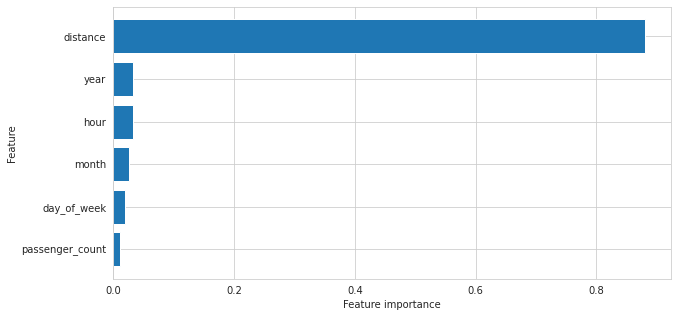

In [ ]:
features = np.array(X.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

Here we could see that our trained model puts a lot of importance on the `distance` feature, followed by the most broad time feature (i.e., the `year` feature), and lastly by the `passenger_count` feature. We see that the number of passengers has little to no effect on the fare amount. Moreover, this tells us that the fare amount can only be accurately predicted once we know the distance traveled. However, it should also be noted that attributes with low feature importance does not mean it is uninformative, but rather it was not picked by the model because other features likely encode the same information. Let us now see how our model performs. To do this, we use our model to predict the fare amount on the training and validation sets.

In [ ]:
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
rmse_train = mean_squared_error(y_train, y_pred_train)**0.5
rmse_val = mean_squared_error(y_val, y_pred_val)**0.5
print(f'RMSE (train): {rmse_train:5.3f}')
print(f'RMSE (val):   {rmse_val:5.3f}')

RMSE (train): 1.504
RMSE (val):   3.824


Results show that we get a RMSE value of \$1.504 when tested on the training set, and a RMSE value of \$3.824 when tested on the validation set. Seeing that the mean fare amount of our pruned dataset is \$11.146, our training RMSE is approximately 13.49% of the mean value, and our validation RMSE is 34.31% of the mean value. A lower percentage would mean higher accuracy in our predictions. However, we wouldn't want to overfit on the training data, and thus we will perform hyperparameter tuning later to avoid this issue.

## Training on Time Features and Passenger Count only

We then repeat the process but consider only the time features and passenger count. We first generate `preprocess_pu` transformer that will take in only the time features.

In [ ]:
preprocess_pu = ColumnTransformer([
    ('time_pipeline', time_pipeline, ['hour', 'day_of_week', 'month', 'year']),
    ('passenger_pipeline', passenger_pipeline, ['passenger_count'])
])

We then split the dataset into training and validation sets.

In [ ]:
X_pu = df.drop(['distance', 'fare_amount'], axis=1)
y_pu = df['fare_amount']

X_train_pu, X_val_pu, y_train_pu, y_val_pu = train_test_split(X_pu, y_pu,
    test_size=0.1, random_state=0)

print(f'Training samples:   {len(X_train_pu)}')
print(f'Validation samples: {len(X_val_pu)}')

X_train_pu = preprocess_pu.fit_transform(X_train_pu)
X_val_pu = preprocess_pu.transform(X_val_pu)

Training samples:   1318763
Validation samples: 146530


Then we perform model training.

In [ ]:
start_time = time()
rf_pu = RandomForestRegressor(n_jobs=-1)
rf_pu.fit(X_train_pu, y_train_pu)
time_elapsed = time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Training complete in 4m 22s


We then extract the feature importances of `rf_pu`.

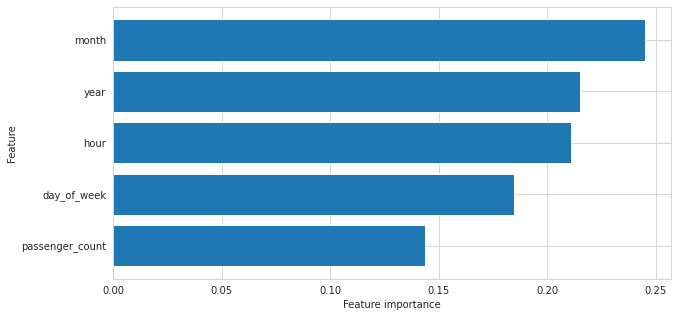

In [ ]:
features_pu = np.array(X_pu.columns)
importances_pu = rf_pu.feature_importances_
indices_pu = np.argsort(importances_pu)

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices_pu)), importances_pu[indices_pu], align='center')
plt.yticks(range(len(indices_pu)), [features_pu[i] for i in indices_pu])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

We see a similar pattern to the feature importances generated by our first model; we still see that the `passenger_count` feature has little effect on the fare amount. Moreover, we now see the `month` feature being given more importance than the `year` feature. Lastly, we test our model on the training and validation sets to see how well it performs.

In [ ]:
y_pred_train = rf_pu.predict(X_train_pu)
y_pred_val = rf_pu.predict(X_val_pu)
rmse_train = mean_squared_error(y_train_pu, y_pred_train)**0.5
rmse_val = mean_squared_error(y_val_pu, y_pred_val)**0.5
print(f'RMSE (train): {rmse_train:5.3f}')
print(f'RMSE (val):   {rmse_val:5.3f}')

RMSE (train): 8.499
RMSE (val):   8.980


Here we see that our model generally performs worse than our first model. However, because the training and validation RMSEs are very close to each other, this tells us that we could be underfitting, as compared the that of our previous model which tells us that we could be overfitting.

# Hyperparameter Tuning

After the initial model training we have just done, we now proceed to hyperparameter tuning. Because the dataset we are dealing with is large, it would be best to reduce the hyperparameter space to search over (i.e., reduce the number of hyperpameters to search over). Therefore, in our `param_grid`, we ssearch only over three hyperparameters: `n_estimators`, `max_depth`, and `max_features`. For `n_estimators`, we search only over the list `[5, 10, 30, 40, 50]`, for the `max_depth` feature we search over the list `[4, 8, None]`, and for the `max_features` hyperparamter we search over the list `[2, 4, 'auto']`.

## Training on Distance, Time Features, and Passenger Count

We first start with the model trained on the distance, time features, and passenger count.

In [ ]:
param_grid = {
    'n_estimators':[5, 10, 30, 40, 50],
    'max_depth':[4, 8, None],
    'max_features':[2, 4, 'auto']
}

rf = RandomForestRegressor(n_jobs=-1)

start_time = time()
gs = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
search = gs.fit(X_train, y_train)
time_elapsed = time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Trining complete in 170m 28s


Let us see what the best parameters are.

In [ ]:
for key in search.best_params_.keys():
    print(f'{key}: {search.best_params_[key]}')

max_depth: 8
max_features: 4
n_estimators: 40


Let us also check the feature importances of the best model.

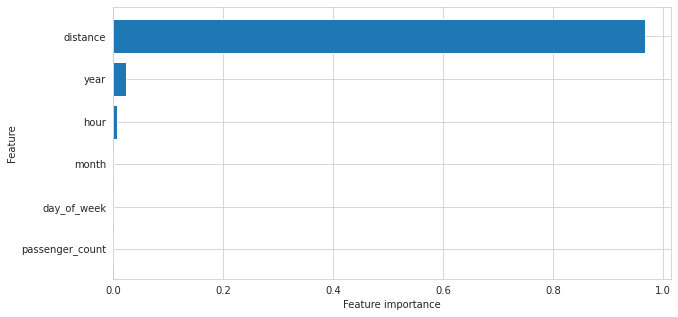

In [ ]:
rf_best = search.best_estimator_
features = np.array(X.columns)
importances = rf_best.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

Once again, we see a very similar pattern of the feature importances to our initial model. This time, however, we see that our model completely removes the `month`, `day_of_week`, and `passenger_count` features (or at least that is what we see in the plot). We will then evaluate its performance on the training and validation sets.

In [ ]:
y_pred_train = rf_best.predict(X_train)
y_pred_val = rf_best.predict(X_val)
rmse_train = mean_squared_error(y_train, y_pred_train)**0.5
rmse_val = mean_squared_error(y_val, y_pred_val)**0.5
print(f'RMSE (train): {rmse_train:5.3f}')
print(f'RMSE (val):   {rmse_val:5.3f}')

RMSE (train): 3.672
RMSE (val):   3.696


This time, we see that the RMSEs of our training and validation predictions are close to each other, indicating that we are probably underfitting. However, we will keep this model as is because it could probably perform better in generalization.

## Training on Time Features and Passenger Count only

We then tune the hyperparameters of the model trained on the time featuers and passenger count only.

In [ ]:
rf_pu = RandomForestRegressor(n_jobs=-1)

start_time = time()
gs_pu = GridSearchCV(rf_pu, param_grid, cv=5, scoring='neg_mean_squared_error')
search_pu = gs_pu.fit(X_train_pu, y_train_pu)
time_elapsed = time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Training complete in 131m 32s


Let us see what the best parameters are.

In [ ]:
for key in search_pu.best_params_.keys():
    print(f'{key}: {search_pu.best_params_[key]}')

max_depth: 8
max_features: 4
n_estimators: 50


The selected best parameters are very similar to our other hyperparameter-tuned model, except that there are 10 more estimators in this model. We would now like to see the feature importances of the best model.

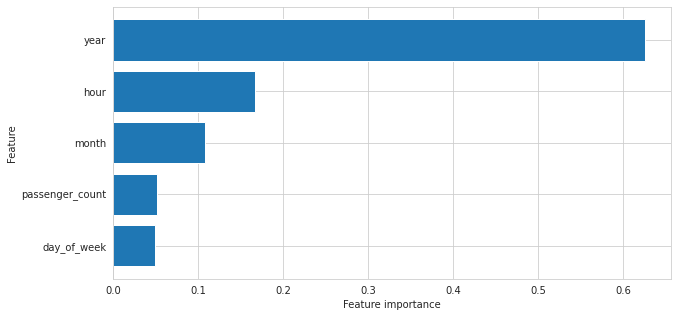

In [ ]:
rf_pu_best = search_pu.best_estimator_
importances_pu = rf_pu_best.feature_importances_
indices_pu = np.argsort(importances_pu)

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices_pu)), importances_pu[indices_pu], align='center')
plt.yticks(range(len(indices_pu)), [features_pu[i] for i in indices_pu])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

Surprisingly enough, the `passenger_count` feature is no longer given the least importance. Moreover, we see that the `year`, `hour`, and `month` features are given the top three most importance. Therefore, we could say that these three features alone could be sufficient enough to predict the fare amount to some degree before the trip has even been made. We now evaluate its performance on the training and validation sets.

In [ ]:
y_pred_train = rf_pu_best.predict(X_train_pu)
y_pred_val = rf_pu_best.predict(X_val_pu)
rmse_train = mean_squared_error(y_train_pu, y_pred_train)**0.5
rmse_val = mean_squared_error(y_val_pu, y_pred_val)**0.5
print(f'RMSE (train): {rmse_train:5.3f}')
print(f'RMSE (val):   {rmse_val:5.3f}')

RMSE (train): 8.771
RMSE (val):   8.734


We see that our model trained only on the time features and passenger count still performs worse than our model that is also trained on the distance feature. Therefore, we conclude that knowing the time when taking a taxi and the number of passengers in the taxi is not enough to predict the fare amount. This tells us that we cannot accurately predict the optimal time for passengers to take a taxi and for drivers to determine the peak hours. This also tells us that taxi drivers cannot determine beforehand which of two trips is more profitable until after the trip has been made.

# Model Testing

At this point, we would like to see how well our models perform on unseen data. Although the scores on the validation set could be a reliable source of determinig the model performance, it is possible that the distributions of the training and validation sets are similar, and thus it does not tell us much about how well our model can generalize to unseen data. That being said, we would like to test our models on the test set of the New York City Taxi Fare Prediction dataset (available [here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data?select=test.csv)).

## Loading and Transforming the Test Dataset

We must first load the dataset and perform the necessary transformations for preprocessing.

In [ ]:
df_test = pd.read_csv('test.csv')

df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['hour'] = df_test['pickup_datetime'].apply(lambda date: date.hour)
df_test['day_of_week'] = df_test['pickup_datetime'].apply(lambda date: date.dayofweek)
df_test['month'] = df_test['pickup_datetime'].apply(lambda date: date.month)
df_test['year'] = df_test['pickup_datetime'].apply(lambda date: date.year)
df_test['distance'] = haversine(df_test, coordinates)
df_test = df_test[['key', 'distance', 'hour', 'day_of_week', 'month', 'year',
    'passenger_count']]
df_test_pu = df_test.copy()

df_test.head()

,key,distance,hour,day_of_week,month,year,passenger_count
0,2015-01-27 13:08:24.0000002,2.323260,13,1,1,2015,1
1,2015-01-27 13:08:24.0000003,2.425353,13,1,1,2015,1
2,2011-10-08 11:53:44.0000002,0.618628,11,5,10,2011,1
3,2012-12-01 21:12:12.0000002,1.961033,21,5,12,2012,1
4,2012-12-01 21:12:12.0000003,5.387301,21,5,12,2012,1


## Model 1 (Trained on Distance, Time Features, and Passenger Count)

We then generate predictions using our first model (trained on the distance, time, and passenger count features).

In [ ]:
X_final = preprocess.transform(df_test.drop(['key'], axis=1)[X.columns])
y_final = rf_best.predict(X_final)
df_test['fare_amount'] = y_final
df_test = df_test[['key', 'fare_amount']]

## Model 2 (Trained on Time Features and Passenger Count only)

Next, we generate predictions using our second model (trained on the time features and passenger count only).

In [ ]:
X_final_pu = preprocess_pu.transform(df_test_pu.drop(['key', 'distance'], axis=1)[X_pu.columns])
y_final_pu = rf_pu_best.predict(X_final_pu)
df_test_pu['fare_amount'] = y_final_pu
df_test_pu = df_test_pu[['key', 'fare_amount']]

## Save Predictions

Lastly, we generate a csv of our predictions and submit them to the Kaggle competition to determine how well our models perform on unseen data.

In [ ]:
df_test.to_csv('ml_full.csv', header=True, index=False)
df_test_pu.to_csv('ml_pu.csv', header=True, index=False)

## Kaggle Results

- Score (model 1): 3.96615
- Score (model 2): 9.28971

The results reinforce our conclusion that time features and passenger count alone are not sufficient enough in predicting the fare amount. Moreover, the distance traveled greatly improves model performance. Therefore, it would be better to deploy our first model (model 1) rather than our second model (model 2).

# Case Summary

## Context

New York City is known for the number of tourists that go in and out of the city every year. Because of the large amount of people in the city, there is a high demand for transportation services to get around the city. Some people would prefer to take the subway or a bus to save money, while others would prefer to take a taxi for more comfort. In this machine learning case study, we look at how the fare amount of taking a taxi can be accurately predicted using several extracted features. This could potentially help commuters determine the optimal time to save money when choosing to take a taxi than to take the bus or subway. This could also potentially help taxi drivers determine the peak hours to maximize profits and to determine which of two trips could possibly yield more profits before the trip has even been made.

## Model Overview and Design

We first perform feature engineering to obtain the necessary features we want to train our models on, namely:
- `distance`: This is obtained by using the Haversine formula that determines the distance between two points on a sphere. The assumption here is that we treat Earth as a perfect sphere, wherein its radius is the average radius of the Earth (approximately 6371 km). This is a continuous variable.
- `hour`: This refers to the hour of the day the taxi ride took place. This, including all other extracted time features, is obtained by first converting the `pickup_datetime` feature to a `datetime` object type using `pandas.to_datetime`. To get the hour of the day feature, we use `df['pickup_datetime'].apply(lambda date: date.hour)`. This is a categorical variable.
- `day_of_week`: This refers to the day of the week the taxi ride took place. To get the day of the week feature, we use `df['pickup_datetime'].apply(lambda date: date.dayofweek)`. This is a categorical variable.
- `month`: This refers to the month of year the taxi ride took place. To get the month of the year feature, we use `df['pickup_datetime'].apply(lambda date: date.month)`. This is a categorical variable.
- `year`: This refers to the year the taxi ride took place. To get the year feature, we use `df['pickup_datetime'].apply(lambda date: date.year)`. This is a categorical variable.
- `passenger`: This refers to the number of passengers in the taxi. This is a categorical variable.

After extracting the necessary features, we perform label-encoding on the categorical variables. Label-encoding is done to convert non-numeric caterogical data into numeric ones. In our case, our categorical variables are already numeric. However, it is still good practice to perform label-encoding on the categorical features. Most people would use one-hot encoding, but this increases the number features, which is not good for any tree-based algorithm. An alternative for this would be to use scikit-learn's `LabelEncoder` but this is sometimes slow, especially when dealing with large datasets. In this case study, we use a modified label-encoder using the pandas library. After performing the necessary preprocessing steps, we then generate two models:
- model 1: trained on all features
- model 2: trained on the time and passenger count features only

The idea behind training two models is that we want one model that is trained on all the extracted features, and a separate model that is trained only on the time and passenger count features. The second model is especially useful when someone wants to predict the fare amount before the trip has even been made. This is especially useful among commuters when they want to know at what time can they save the most money when taking a taxi; and it is equally useful among drivers to determine the peak hours to maximize profits.

After the initial training, we tune the hyperparameters of our models using scikit-learn's `GridSearchCV`. This helps us determine the best set of hyperparameters to use, and it uses cross-validation internally to help boost training.

## Assessment

For out metric used to evaluate model performance, we use the Root Mean Squared Error (RMSE) because we are dealing with continuous data. The advantage of RMSE over the Mean Absolute Error (MAE) is that the MAE is a linear score which means that individual differences are weighted equally in the average, whereas the RMSE is a quadratic scoring rule which measures the average magnitude of the error. Thus, the RMSE gives a relatively high weight to large errors. After the initial training of our models (before using `GridSearchCV`), we see that model 1 (validation RMSE: \\$3.824) outperforms model 2 (validation RMSE: \\$8.980). This tells us that the the fare amount cannot be accurately predicted before the trip has been made. Comparing the validation score of model 1 (\\$3.824) to its training score (\\$1.504), it is possible that we may be overfitting on the training set, which is undesirable when we want to deploy our model and test it on unseen data, especially when its distribution is different from that learned in the training set.

After applying `GridSearchCV`, the validation score of model 1 decreased to \\$3.696, and that of model 2 decreased to \\$8.734. The important features determined by model 1 tells us that the `distance` feature encodes the most information for determining the fare amount. Among the time features, the `year` feature is shown to encode the most information, followed by the `hour` feature. The other features (`day_of_week`, `month`, and `passenger_count`) has been shown to be given less importance. This tells us that regardless of the distance traveled, one could predict the fare amount to some degree given the hour of the day and year only. However, it should also be noted that attributes with low feature importance does not mean it is uninformative, but rather it was not picked by the model because other features likely encode the same information.

The two hyperparameter-tuned models were also tested on the test set of the New York City Taxi Fare Prediction (availabel [here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data?select=test.csv)). Model 1 obtained a score of 3.96615, whereas model 2 obtained a score of 9.28971. This reinforces our conclusion that knowing the time and number of passengers only is not enough to accurately predict the fare amount; the distance traveled is the best source for accurately predicting the fare amount.

## Application

As mentioned earlier, the insights drawn from this machine learning case study could help both commuters and taxi drivers. It could help commuters to determine the best time to take a taxi to save money, rather than to take the bus or subway which could be uncomfortable at times. It could also help taxi drivers determine the best time to focus their resources to maximize profits. Another possible benefit of these models is that it could help new competitors in the land transportation industry (e.g., new taxi companies) determine the best aspects to focus on when first starting out. It is possible that new startups fail due to focusing on the wrong aspects. By using the insights from this case study and the predictions of the proposed models, it could prove to be benetifial to both the taxi companies and its users.

## Sustainability

In this case study, only 1500000 of the 26173536 training samples were used, which comprises only 5.73\% of the entire dataset. The choice on the number of training samples to be used was severely limited due to maximum RAM available, even when using Google Colaboratory. That being said, this issue could be overcome by using other Python libraries and techniques designed specifically to deal with big data, an example of which is [PySpark](https://spark.apache.org/docs/latest/api/python/index.html).

Assuming that loading the entire dataset has been accomplished, another issue that was present during this case study was the choice of the machine learning model to train. Random Forests (RF) were used mainly because it has been proven time and time again to be one of the best machine learning models out there; it has also been one of the most popular choice of machine learning models in Kaggle competitions. One great benefit of using scikit-learn's `RandomForestRegressor` is that it enables us to further train on new data, as long as they contain the same necessary features extracted in this case study. This allows the company to continuously collect data and train our model on the new data. However, the incremental training of the `RandomForestRegressor` does not fit entirely new models, but adds successive trees. In the long run, this could prove to be a problem for the company, but it is still unlikely. An alternative choice would be to use neural networks. With the use of GPUs and CUDA support, neural networks could learn more complex mappings between training and target variables, thus improving both model runtime and performance.


Recommendations:
- Use more data during training
- Perform a more broad search during hyperparameter tuning
- Extract more features during feature engineering (an example of this would be to group pickup and dropoff longitudes and latitudes to sections of New York City, but this would require knowledge of the city of New York and advanced feature engineering techniques) 